

# Alexa Project Code Contribution

> Author: Chet (techds on GitHub)  
> * Multilayer perceptron (MLP) or Dense NN (DNN):  
>   * audio data ingestion (mfcc features saved to .npy files)  
>   * model prediction  


In [1]:
# imports

import numpy as np
np.random.seed(200) 
import tensorflow as tf
from tensorflow import set_random_seed 
set_random_seed(300)

from keras import optimizers
from keras.layers import AveragePooling2D, BatchNormalization, Conv2D, \
                         MaxPooling2D, Dense, Dropout, Activation, Flatten,\
                         ZeroPadding2D
from keras.models import load_model
from keras.models import Sequential
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle as sh

import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
from pydub import AudioSegment as audio
from pydub.playback import play 
import re

# functions

def plot_loss_acc(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['acc'], 'o-', c='r')
    ax.plot([None] + hist.history['val_acc'], '*-', c='g')
    ax.legend(['Train acc', 'Val acc'], loc = 0)
    ax.set_title('Training/Validation Accuracy per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-', c='r')
    ax.plot([None] + hist.history['val_loss'], '*-', c='g')
    ax.legend(['Train loss', 'Val loss'], loc = 0)
    ax.set_title('Training/Validation Loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss') 
    plt.plot()
    
def tag_cols(df,beg_str,last_col_name):
    colnames = []
    beg_str = str(beg_str)
    len_col = len(df.columns)
    for l in range(len_col-1 ):
        name = beg_str + str(l+1)
        colnames.append(name)
    last_col_name = str(last_col_name)
    colnames.append(last_col_name)
    df.columns = colnames
    
print('Ready for data ingestion and model prediction')


Using TensorFlow backend.


Ready for data ingestion and model prediction


In [2]:
# create df of training data features and labels from saved features file.
tr_mfcc = np.load('./Desktop/25_features_mfcc_train.npy')
tr_mfcc_df = pd.DataFrame(list(map(np.ravel, tr_mfcc)))
tr_mfcc_df.columns = ['feature','label']

tr_mfcc_df2 = pd.DataFrame(tr_mfcc_df['feature'].values.tolist() )
trainf_df = pd.concat([tr_mfcc_df2, tr_mfcc_df.label], axis=1)
tag_cols(trainf_df,'f','label') 

trainf_df[0:3]


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,label
0,-338.044529,107.832624,-8.599863,49.250348,4.054716,-2.068923,-21.844524,-16.274585,-4.601480,-2.521300,...,-8.783644,-4.230033,-3.409027,-2.882555,-2.431158,-7.108211,-0.874338,-2.797660,-7.666226,mikio_d
1,-327.008532,93.919808,-17.079697,31.987199,-6.696296,-1.553129,-11.870062,-8.161606,-6.949227,0.971683,...,-11.093544,-6.258163,-7.134278,-6.126257,-7.727422,-8.087452,-9.626957,-5.617373,-8.749785,rene_g
2,-316.934038,53.243102,-76.172196,12.368152,-3.549103,-18.639859,-44.572615,12.543678,-20.792307,-1.821228,...,-16.639423,-4.259079,-7.051992,-7.431469,-7.571922,-1.868029,-3.994799,2.889429,3.143325,rachel_m


In [3]:
# create df of training data features and labels from saved features file.
te_mfcc = np.load('./Desktop/25_features_mfcc_test.npy')
te_mfcc_df = pd.DataFrame(list(map(np.ravel, te_mfcc)))
te_mfcc_df.columns = ['feature','label']

te_mfcc_df2 = pd.DataFrame(te_mfcc_df['feature'].values.tolist() )
testf_df = pd.concat([te_mfcc_df2, te_mfcc_df.label], axis=1)
tag_cols(testf_df,'f','label')

testf_df[0:3]


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,label
0,-351.296923,94.099958,0.590502,34.820978,-14.364128,21.638371,-15.785959,3.455809,-14.946200,-11.285081,...,-9.326795,-7.947879,-10.988181,-9.721337,-8.737192,-3.928657,-10.108051,-2.498840,-0.955104,serhad_k
1,-293.127642,143.587180,-32.704374,42.709656,-4.666671,10.297830,-20.553964,-18.119747,-14.026293,-1.143952,...,-5.710474,-8.885007,1.352289,-5.804005,-3.664169,-1.593806,-4.117430,-1.917218,-3.832038,mikio_d
2,-392.183611,132.630387,5.576211,14.507040,4.926874,-4.470060,-11.852281,9.654318,-6.133299,2.791487,...,-2.497406,-3.244148,-0.068503,-3.993311,0.275478,-2.732089,-1.098079,0.687095,-2.713171,pooja_r


In [5]:
# prepare data
le = LabelEncoder()

x_train = np.array(tr_mfcc_df.feature.tolist())
y_train = np.array(tr_mfcc_df.label.tolist())
y_train_cat = np_utils.to_categorical(le.fit_transform(y_train))

x_test = np.array(te_mfcc_df.feature.tolist())
y_test = np.array(te_mfcc_df.label.tolist())
y_test_cat = np_utils.to_categorical(le.fit_transform(y_test))

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('x_train shape:', x_train.shape,'\t', 'y_train shape:', y_train.shape)
print('x_test shape :', x_test.shape,'\t', 'y_test shape :', y_test.shape)
    

x_train shape: (850, 25) 	 y_train shape: (850,)
x_test shape : (50, 25) 	 y_test shape : (50,)


In [6]:
speakers = le.classes_
num_labels = y_train_cat.shape[1]
num_features = 25


print('speaker labels for this dataset:\n')
print(speakers)


speaker labels for this dataset:

['anderson_c' 'chet_s' 'jack_x' 'ken_r' 'meghan_m' 'mikio_d' 'pooja_r'
 'rachel_m' 'rene_g' 'serhad_k']


In [7]:
# Create a multilayer perceptron (mlp) 
dnn = Sequential()

# input layer
dnn.add(Dense(128, input_shape=(num_features,)))
dnn.add(BatchNormalization())
dnn.add(Activation('relu'))
dnn.add(Dropout(0.5))

# hidden layers
dnn.add(Dense(64))
dnn.add(BatchNormalization())
dnn.add(Activation('relu'))
dnn.add(Dropout(0.5))

dnn.add(Dense(32))
dnn.add(BatchNormalization())
dnn.add(Activation('relu'))
dnn.add(Dropout(0.25))

dnn.add(Dense(16))
dnn.add(BatchNormalization())
dnn.add(Activation('relu'))
dnn.add(Dropout(0.25))

# output layer
dnn.add(Dense(num_labels))
dnn.add(BatchNormalization())
dnn.add(Activation(tf.nn.softmax))

model = dnn
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3328      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

In [8]:
# compile and fit the model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer=optimizers.SGD(lr=0.0001, 
                                       momentum=0.9))

print('\nTraining...\n')
hist_dnn = model.fit(x_train, y_train_cat,
                     batch_size=32, epochs=120,     
                     validation_data = (x_test, y_test_cat))



Training...

Train on 850 samples, validate on 50 samples
Epoch 1/120
850/850 [==============================] - 1s 808us/step - loss: 2.6789 - acc: 0.0929 - val_loss: 2.3444 - val_acc: 0.1000
Epoch 2/120
850/850 [==============================] - 0s 167us/step - loss: 2.6487 - acc: 0.1188 - val_loss: 2.3321 - val_acc: 0.0800
Epoch 3/120
850/850 [==============================] - 0s 169us/step - loss: 2.5717 - acc: 0.1282 - val_loss: 2.3195 - val_acc: 0.1000
Epoch 4/120
850/850 [==============================] - 0s 167us/step - loss: 2.5868 - acc: 0.1000 - val_loss: 2.3052 - val_acc: 0.0800
Epoch 5/120
850/850 [==============================] - 0s 174us/step - loss: 2.6143 - acc: 0.0941 - val_loss: 2.2891 - val_acc: 0.1000
Epoch 6/120
850/850 [==============================] - 0s 165us/step - loss: 2.5327 - acc: 0.1271 - val_loss: 2.2727 - val_acc: 0.1000
Epoch 7/120
850/850 [==============================] - 0s 165us/step - loss: 2.5329 - acc: 0.1459 - val_loss: 2.2595 - val_acc: 0.1

Epoch 61/120
850/850 [==============================] - 0s 188us/step - loss: 1.9273 - acc: 0.3153 - val_loss: 1.7332 - val_acc: 0.6200
Epoch 62/120
850/850 [==============================] - 0s 215us/step - loss: 1.9660 - acc: 0.3153 - val_loss: 1.7258 - val_acc: 0.6000
Epoch 63/120
850/850 [==============================] - 0s 195us/step - loss: 1.8892 - acc: 0.3282 - val_loss: 1.7214 - val_acc: 0.6200
Epoch 64/120
850/850 [==============================] - 0s 182us/step - loss: 1.9447 - acc: 0.3176 - val_loss: 1.7117 - val_acc: 0.6200
Epoch 65/120
850/850 [==============================] - 0s 213us/step - loss: 1.9097 - acc: 0.3188 - val_loss: 1.7088 - val_acc: 0.6000
Epoch 66/120
850/850 [==============================] - 0s 190us/step - loss: 1.9429 - acc: 0.3388 - val_loss: 1.7096 - val_acc: 0.6200
Epoch 67/120
850/850 [==============================] - 0s 187us/step - loss: 1.9443 - acc: 0.3059 - val_loss: 1.7011 - val_acc: 0.6200
Epoch 68/120
850/850 [==========================

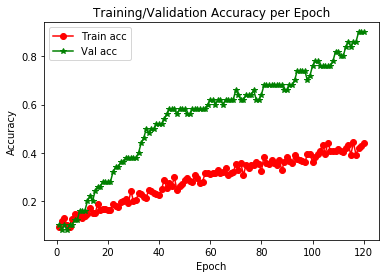

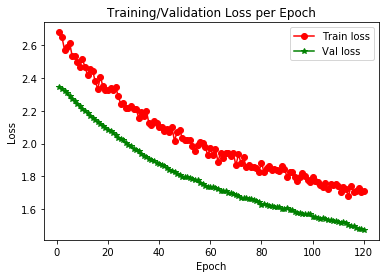

In [9]:
plot_loss_acc(hist_dnn)


In [10]:
te_acc = model.evaluate(x_test, y_test_cat, verbose=False)[1]
print('DNN test accuracy:', te_acc,'\n')


DNN test accuracy: 0.8999999952316284 



In [11]:
# sample voice command authentication (using cell-phone recording)

clip_path = './Desktop/flask_apps/'
filename = 'audio_m.wav'
clip = os.path.join(clip_path, filename)
#print(clip)


In [21]:
from pydub import AudioSegment as audio
from pydub.playback import play 


audio_file = audio.from_wav(clip)
print('Playing ... ', clip[-12:])
play(audio_file)


Playing ...  /audio_m.wav


In [12]:
audio_dat, sample_rate = librosa.load(clip, 
                                      res_type='kaiser_fast')  

x_rt = np.mean(librosa.feature.mfcc(y = audio_dat, 
                        sr = sample_rate, 
                        n_mfcc = num_features).T,
                        axis = 0) 

x_rt_t = x_rt.reshape(1, num_features) 
x_rt_t = scaler.transform(x_rt_t)
print(x_rt_t.shape)


(1, 25)


In [13]:
rt_class_prob = model.predict(x_rt_t)
rt_class_prob_rs = rt_class_prob.reshape(len(speakers),1)
rt_class_prob_df = pd.DataFrame(list(map(np.ravel, rt_class_prob_rs)))
rt_class_prob_df.columns = ['f']
rt_class_prob_df


,f
0,0.118856
1,0.064343
2,0.171298
3,0.057362
4,0.051745
5,0.098502
6,0.165799
7,0.082191
8,0.084006
9,0.105899


In [14]:
prob_thresh = .95
num_prob_thresh = 0
rt_class_prob_ls = np.array(rt_class_prob_df['f'].tolist())
max_prob = np.max(rt_class_prob_ls)
max_prob_val = round(max_prob * 100,2)
max_prob_ind = rt_class_prob_ls.tolist().index(max_prob) 
rt_pred_label = speakers[max_prob_ind]
rt_pred_label = re.sub('\_(.*)','',rt_pred_label)
print('I\'m %s%% sure that you are %s.'\
      % (max_prob_val, rt_pred_label.upper()) )


I'm 17.13% sure that you are JACK.
